<a href="https://colab.research.google.com/github/sourav22899/ee5111-estimation-theory/blob/master/Copy_of_concrete_dropout_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May 10 16:11:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import sys
import numpy as np
np.random.seed(0)

# Main code for Concrete Dropout

In [3]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Layer


class ConcreteDropout(Layer):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(**kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)
        self.layer = layer

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build(input_shape=None)  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer) # Eq 3 of the paper.

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using TensorFlow backend.


# Evaluate Concrete Dropout on synthetic data

In [0]:
Ns = [10, 25, 50, 100, 1000, 10000] # Number of data points 
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2] 
nb_val_size = 1000 # validation test size
nb_features = 1024 # Number of features, which is the number of units in the MLP
Q = 1 # dimension of data
D = 1 # One mean and one var
K_test = 20 # Number of MC samples
nb_reps = 3
batch_size = 20
l = 1e-4 # length scale

In [0]:
def gen_data(N):
    sigma = 1e-0  # ground truth
    X = np.random.randn(N, Q)
    w = 1.
    b = 8.
    Y = 2*np.sin(X) + b + sigma * np.random.randn(N, D) # y = sinx+1+noise
    return X, Y

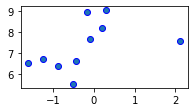

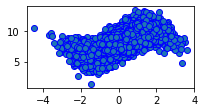

In [8]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
# pylab.xlim([-5, 5])
# pylab.ylim([-10, 10])
pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

### Fit function:

In [0]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    mean = ConcreteDropout(Dense(D), weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(D), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = Concatenate()([mean, log_var])
    # out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 5  # a loss for each Concrete Dropout layer
    hist = model.fit(X, Y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)
    loss = hist.history['loss'][-1]
    return model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [0]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, MC_samples):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    mean = MC_samples[:, :, :D]  # K x N x D
    logvar = MC_samples[:, :, D:]
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_true[None])**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi)
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_true)**2.)**0.5
    return pppp, rmse

### Plot function to make sure stuff makes sense:

In [0]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean[:, 0], c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

#Run experiment

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


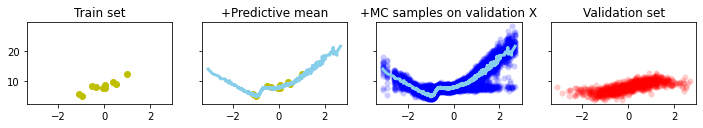

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


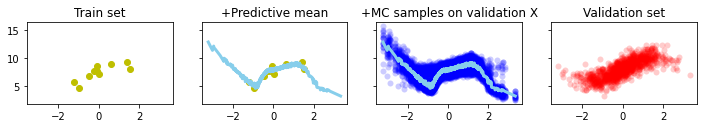

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


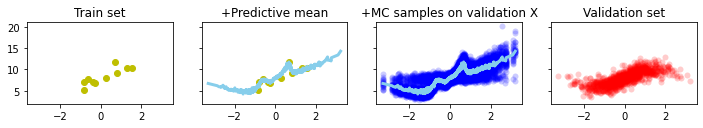

10 2000 - 1.819786676034445 0.27394239391466535 [0.08069903 0.4037045  0.40353438 0.40342164 0.40383318]  -  0.9553167750968276 0.9224043797090411


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


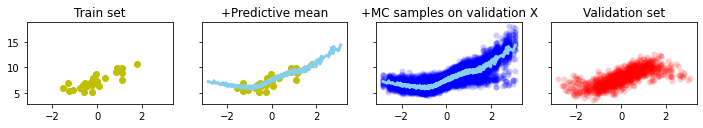

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


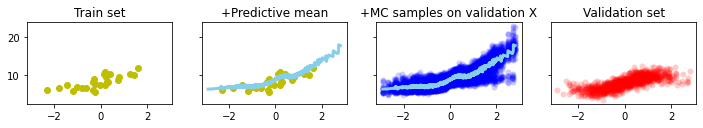

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


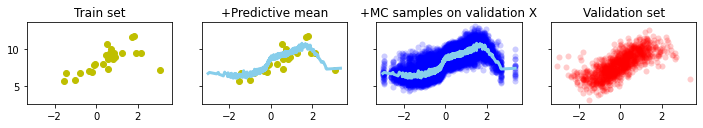

25 1000 - 1.3384863068289095 0.13993059638027258 [0.07430106 0.4034773  0.40328622 0.4028969  0.4038264 ]  -  1.067468247131231 0.7917442451077589


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


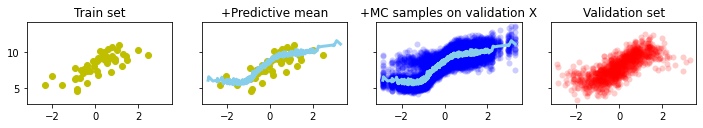

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


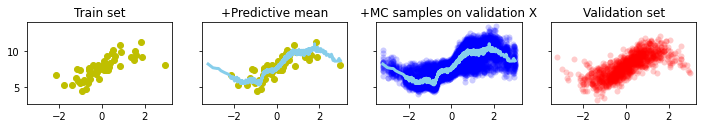

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


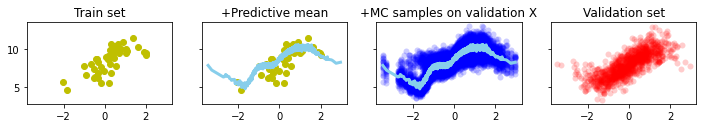

50 500 - 1.1255857540178102 0.051585386329248625 [0.0741786  0.3254904  0.32528317 0.32529315 0.32580468]  -  1.1197050844771217 0.6924657301221266


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


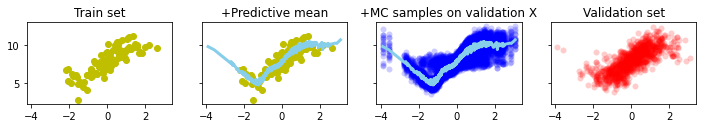

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


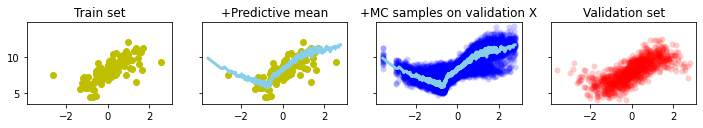

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


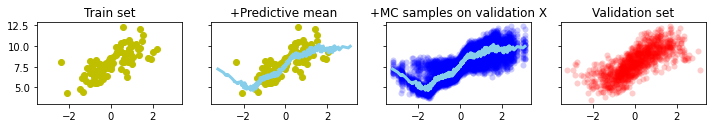

100 200 - 1.126940826073776 0.022181186276926824 [0.08076823 0.23589252 0.23580362 0.23572664 0.23609395]  -  1.1751941216190005 0.6258430755210834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


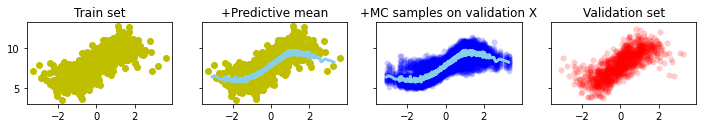

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


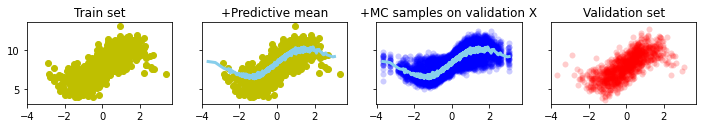

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


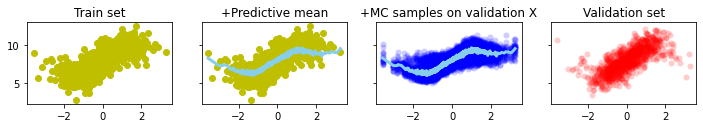

1000 20 - 1.060061272337374 0.01320530290580134 [0.08240589 0.23062702 0.22913803 0.22483365 0.23467457]  -  1.1935523044198462 0.5475170453784381


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


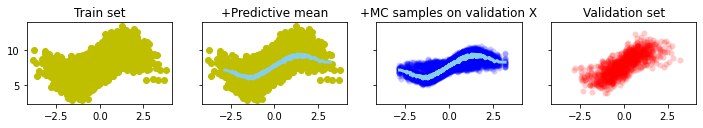

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


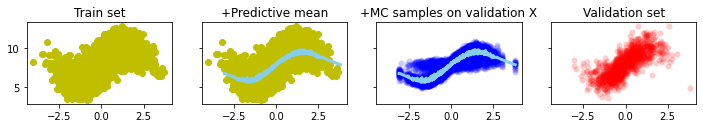

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


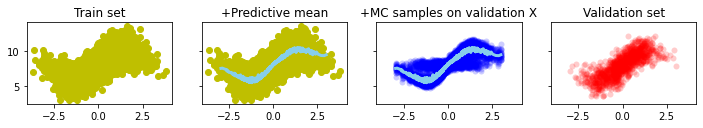

10000 2 - 1.0564531952109222 0.0020656165711123984 [0.08246198 0.13746803 0.13229084 0.11320788 0.17898433]  -  1.165528622240213 0.46616807987540826


In [12]:
results = []
# get results for multiple N
for N, nb_epoch in zip(Ns, nb_epochs):
    # repeat exp multiple times
    rep_results = []
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model, ELBO = fit_model(nb_epoch, X_train, Y_train)
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)]) # predicting the outcome of the validation set K_test times.
        pppp, rmse = test(Y_val, MC_samples)  # per point predictive probability
        means = MC_samples[:, :, :D]  # K x N
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(MC_samples[:, :, D:], 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print(N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5)
    sys.stdout.flush()
    results += [rep_results]

In [0]:
import pickle
with open('concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [0]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [14]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print (best_tests.mean(0))
print (best_ps.mean(1))

[1.81978668 1.33848631 1.12558575 1.12694083 1.06006127 1.0564532 ]
[[0.08069903 0.4037045  0.40353438 0.40342164 0.40383318]
 [0.07430106 0.4034773  0.40328622 0.4028969  0.4038264 ]
 [0.0741786  0.3254904  0.32528317 0.32529315 0.32580468]
 [0.08076823 0.23589252 0.23580362 0.23572664 0.23609395]
 [0.08240589 0.23062702 0.22913803 0.22483365 0.23467457]
 [0.08246198 0.13746803 0.13229084 0.11320788 0.17898433]]


In [0]:
# For y = 2x+8+noise
[1.81928538 1.14594724 1.12591634 1.17073518 1.05162179 1.19302014]
[[0.07611649 0.4036108  0.4034489  0.40331313 0.40380612]
 [0.06776965 0.40355524 0.40320125 0.40301678 0.40382767]
 [0.0728013  0.3255002  0.3253894  0.32522675 0.3258014 ]
 [0.0792399  0.23603392 0.23591031 0.2357623  0.23626898]
 [0.07445221 0.23132448 0.2295965  0.22461201 0.23518544]
 [0.08015967 0.13858251 0.1304171  0.11228159 0.16392216]]

# For y = x**2+1+noise
 [1.49366871 1.45051128 1.14257551 1.07913719 1.03811715 1.05399429]
[[0.08410864 0.40355107 0.4034741  0.40362993 0.40378985]
 [0.08799125 0.40360335 0.40342498 0.40369415 0.40385565]
 [0.08780345 0.32567525 0.325659   0.3258537  0.3259364 ]
 [0.08419317 0.23618619 0.23607223 0.23617978 0.23623504]
 [0.08515996 0.23540373 0.23310244 0.23513608 0.23531725]
 [0.0874087  0.20008309 0.17234887 0.19445215 0.20452316]]

# For y = x+1+noise
 [4.69825323 1.22846986 1.11982483 1.03485399 1.01743298 0.99458961]
[[0.09483521 0.4037325  0.4035211  0.40376914 0.4038709 ]
 [0.08144642 0.40368095 0.4034846  0.4037665  0.40392146]
 [0.07865731 0.32567313 0.325547   0.3256582  0.32574633]
 [0.08172179 0.23622833 0.23614056 0.23623867 0.23627137]
 [0.07691262 0.23574895 0.23515476 0.23574398 0.23598719]
 [0.07392594 0.21943219 0.1951102  0.2099709  0.22846329]]

# For y = 2sin(x)+8+noise
 [1.81978668 1.33848631 1.12558575 1.12694083 1.06006127 1.0564532 ]
[[0.08069903 0.4037045  0.40353438 0.40342164 0.40383318]
 [0.07430106 0.4034773  0.40328622 0.4028969  0.4038264 ]
 [0.0741786  0.3254904  0.32528317 0.32529315 0.32580468]
 [0.08076823 0.23589252 0.23580362 0.23572664 0.23609395]
 [0.08240589 0.23062702 0.22913803 0.22483365 0.23467457]
 [0.08246198 0.13746803 0.13229084 0.11320788 0.17898433]]

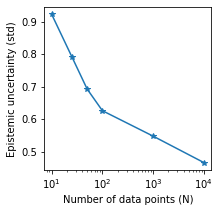

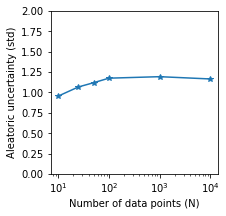

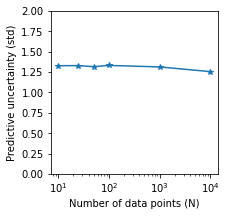

In [15]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('aleatoric.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

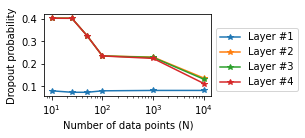

In [16]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()

# MNIST dataset

In [0]:
Q = 28*28
nb_features = 512
num_classes = 10

In [6]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print('x_train shape:', X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 784)


In [0]:
import keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras import backend as K

def fit_model_1(nb_epoch, X, Y):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    print(N,wd,dd)
    inp = Input(shape=(Q,))
    x = inp
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = ConcreteDropout(Dense(num_classes, activation='softmax'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    # out = ConcreteDropout(Dense(), weight_regularizer=wd, dropout_regularizer=dd)(x)
    # log_var = ConcreteDropout(Dense(D), weight_regularizer=wd, dropout_regularizer=dd)(x)
    # out = Concatenate()([mean, log_var])
    # out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 4  # a loss for each Concrete Dropout layer
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=1)
    loss = hist.history['loss'][-1]
    return model, -0.5 * loss  # return ELBO up to const.

In [26]:
nb_epoch = 500
model, ELBO = fit_model_1(nb_epoch,X_train,y_train)
MC_samples = np.array([model.predict(X_test) for _ in range(K_test)])
ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
sys.stdout.flush()

60000 1.6666666666666667e-13 3.3333333333333335e-05
Epoch 1/500
60000/60000 [==============================] - 14s 233us/step - loss: 0.2010
Epoch 2/500
60000/60000 [==============================] - 14s 229us/step - loss: 0.0956
Epoch 3/500
60000/60000 [==============================] - 14s 229us/step - loss: 0.0691
Epoch 4/500
60000/60000 [==============================] - 14s 231us/step - loss: 0.0523
Epoch 5/500
60000/60000 [==============================] - 14s 235us/step - loss: 0.0454
Epoch 6/500
60000/60000 [==============================] - 14s 233us/step - loss: 0.0373
Epoch 7/500
60000/60000 [==============================] - 14s 229us/step - loss: 0.0275
Epoch 8/500
60000/60000 [==============================] - 14s 229us/step - loss: 0.0314
Epoch 9/500
60000/60000 [==============================] - 14s 230us/step - loss: 0.0298
Epoch 10/500
60000/60000 [==============================] - 14s 229us/step - loss: 0.0221
Epoch 11/500
60000/60000 [==============================]

In [29]:
# print(model.summary())
acc = model.evaluate(X_test,  y_test, verbose=0)
acc

10.09245765568614

In [0]:
results = []
# get results for multiple N
for N, nb_epoch in zip(Ns, nb_epochs):
    # repeat exp multiple times
    rep_results = []
    for i in range(nb_reps):
        model, ELBO = fit_model_1(nb_epoch, X_train, y_train)
        MC_samples = np.array([model.predict(X_test) for _ in range(K_test)]) # predicting the outcome of the validation set K_test times.
        pppp, rmse = test(y_test, MC_samples)  # per point predictive probability
        means = MC_samples[:, :, :D]  # K x N
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(MC_samples[:, :, D:], 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5
    sys.stdout.flush()
    results += [rep_results]